<a href="https://colab.research.google.com/github/dancher00/Experimental-Data-Analysis/blob/main/vehicle_tracking_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 10
## Vehicle tracking based on GPS and odometry data fusion
Team 1:
- **Alexey Kotcov**
- **Roman Khalikov**
- **Danil Belov**

This world have never seen such a good team perfomance, as it was during this assignments. All of us was involved and thats why we succesfully made that.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving theta.txt to theta.txt


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(44)

In [ ]:
with open('theta.txt', 'r') as file:
    theta = [float(line.strip()) for line in file]
theta = np.array(theta)

In [ ]:
# Initial conditions

t = 0.05

x_0 = 0
y_0 = 0

v_0 = 10

sigma_a = 1

n = 500

sigma_eta = 3

In [ ]:
def generate_trajectory():

    a_x = np.random.normal(0, sigma_a, n)
    a_y = np.random.normal(0, sigma_a, n)

    eta_x = np.random.normal(0, sigma_eta, n)
    eta_y = np.random.normal(0, sigma_eta, n)

    v_x = np.zeros(n)
    v_y = np.zeros(n)

    v_x[0] = v_0
    v_y[0] = v_0

    x = np.zeros(n)
    y = np.zeros(n)

    x[0] = x_0
    y[0] = y_0

    z_x = np.zeros(n)
    z_y = np.zeros(n)


    for i in range(1, n):
        v_x[i] = 10 * np.cos(theta[i-1])
        v_y[i] = 10 * np.sin(theta[i-1])

        x[i] = x[i-1] + 10 * np.cos(theta[i-1])*t + a_x[i-1] * t/2
        y[i] = y[i-1] + 10 * np.sin(theta[i-1])*t + a_y[i-1] * t/2

        z_x[i] = x[i] + eta_x[i]
        z_y[i] = y[i] + eta_y[i]

    X =  np.array( ([x],
                   [v_x],
                    [y],
                   [v_y]))

    z = np.array([z_x, z_y])
    # v = np.sqrt(np.sum(v_x**2, v_y**2))

    return X, z

In [ ]:
F = np.eye(4)
F[0,1] = t
F[2,3] = t

G = np.zeros((4,2))
G[0,0] = t**2 / 2
G[1,0] = t
G[2,1] = t**2 / 2
G[3,1] = t

Q = G @ G.T * 5**2

R = np.zeros([2,2])
R[0,0] = sigma_eta**2
R[1,1] = sigma_eta**2

P = np.eye(4) * 10**4

H = np.array([[1,0,0,0],[0,0,1,0]])

In [ ]:
X, z = generate_trajectory()

In [ ]:
def kalman(z):

  x_pred = np.zeros(n, dtype='float64')
  y_pred = np.zeros(n, dtype='float64')
  x_f = np.zeros(n, dtype='float64')
  y_f = np.zeros(n, dtype='float64')

  X = np.array(([z[0][2]],
      [(z[0][2] - z[0][1]) / t],
              [z[1][2]],
      [(z[1][2] - z[1][1]) / t]))

  # X = np.array(([0],
  #   [0],
  #   [0],
  #   [0]))



  P_fil = np.eye(4) * 10**4

  for i in range(3,n):

      # Pred

      X = F @ X

      x_pred[i] = X[0]
      y_pred[i] = X[2]

      P_pred = F @ P_fil @ F.T + Q

      K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)

      # Filtr
      P_fil = (np.eye(np.shape(P_pred)[0]) - K @ H) @ P_pred


      X = X + K @ (z[:,i:(i+1)] - H @ X)

      x_f[i] = X[0]
      y_f[i] = X[2]

  return x_pred, y_pred, x_f, y_f

In [ ]:
x_pred, y_pred, x_f, y_f = kalman(z)

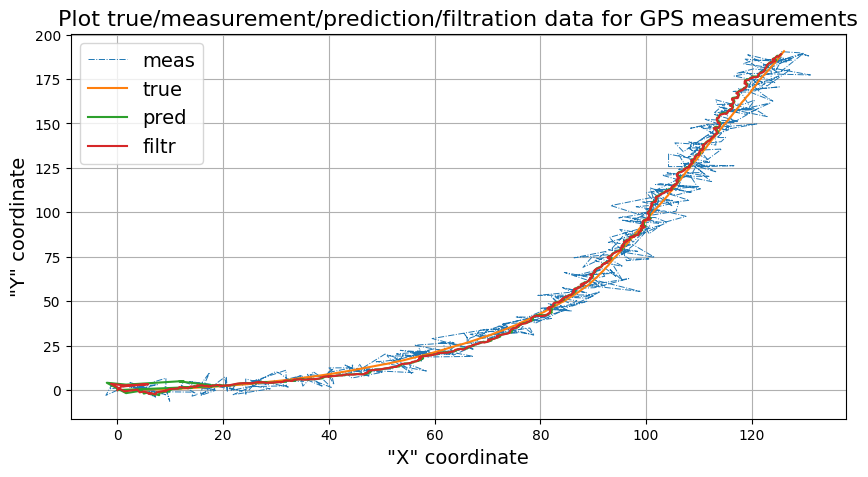

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(z[0,:],z[1,:],linestyle='dashdot', linewidth = 0.7)
plt.plot(X[0,:,1:].T,X[2,:,1:].T)
plt.plot(x_pred,y_pred, label = 'pred')
plt.plot(x_f,y_f, label = 'f')
plt.title('Plot true/measurement/prediction/filtration data for GPS measurements', fontsize=16)
plt.legend(['meas','true','pred','filtr'], fontsize=14)
plt.xlabel('"X" coordinate', fontsize=14)
plt.ylabel('"Y" coordinate', fontsize=14)
plt.grid()
plt.show()

As we can see our measurements are really noisy, but still we can predict and filtrate using our Kalman algorithm and achieve very accurate trajectories **very close to ideal one**.

In [ ]:
M = 500

error_x_pred =  np.zeros(M)
error_x_filtr =  np.zeros(M)

error_y_pred =  np.zeros(M)
error_y_filtr =  np.zeros(M)

for i in range(M):

    X, z = generate_trajectory()
    x_pred, y_pred, x_f, y_f = kalman(z)

    error_x_pred += (x_pred - z[0,:])**2
    error_x_filtr += (x_f - z[0,:])**2

    error_y_pred += (y_pred - z[1,:])**2
    error_y_filtr += (y_f - z[1,:])**2


error_x_pred_f = np.sqrt((error_x_pred)/(M-1))[2:]
error_x_filtr_f = np.sqrt((error_x_filtr)/(M-1))[2:]

error_y_pred_f = np.sqrt((error_y_pred)/(M-1))[2:]
error_y_filtr_f = np.sqrt((error_y_filtr)/(M-1))[2:]

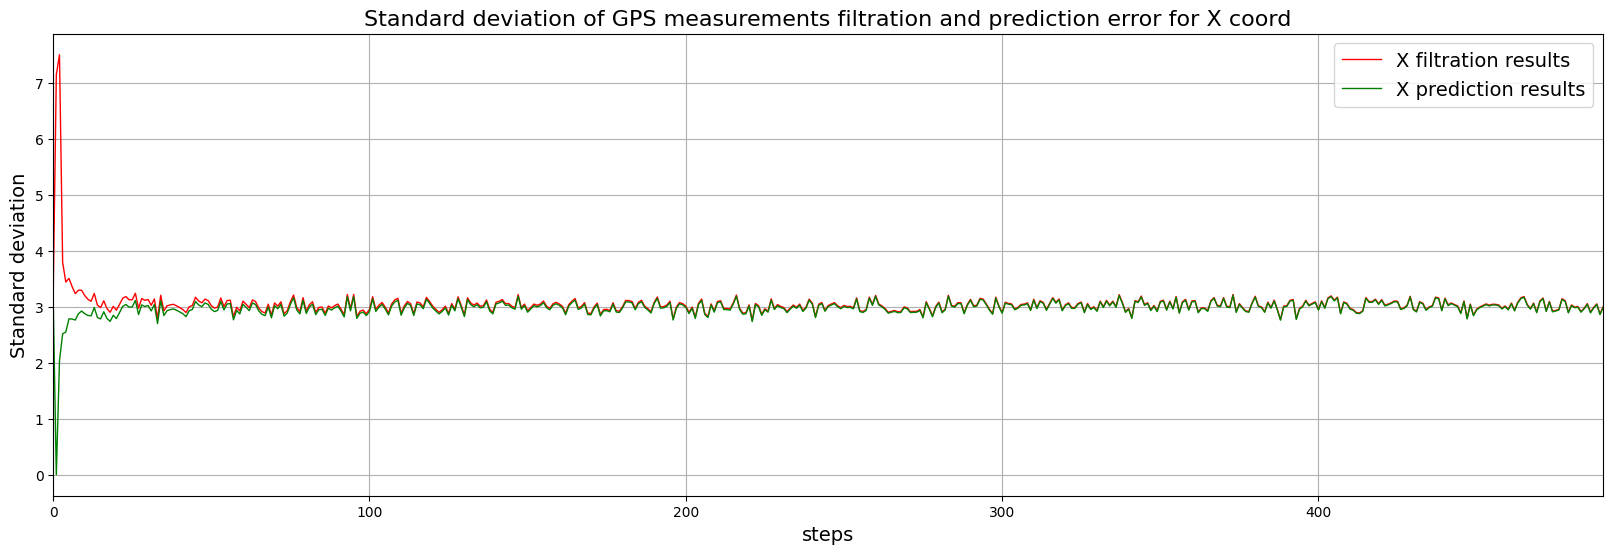

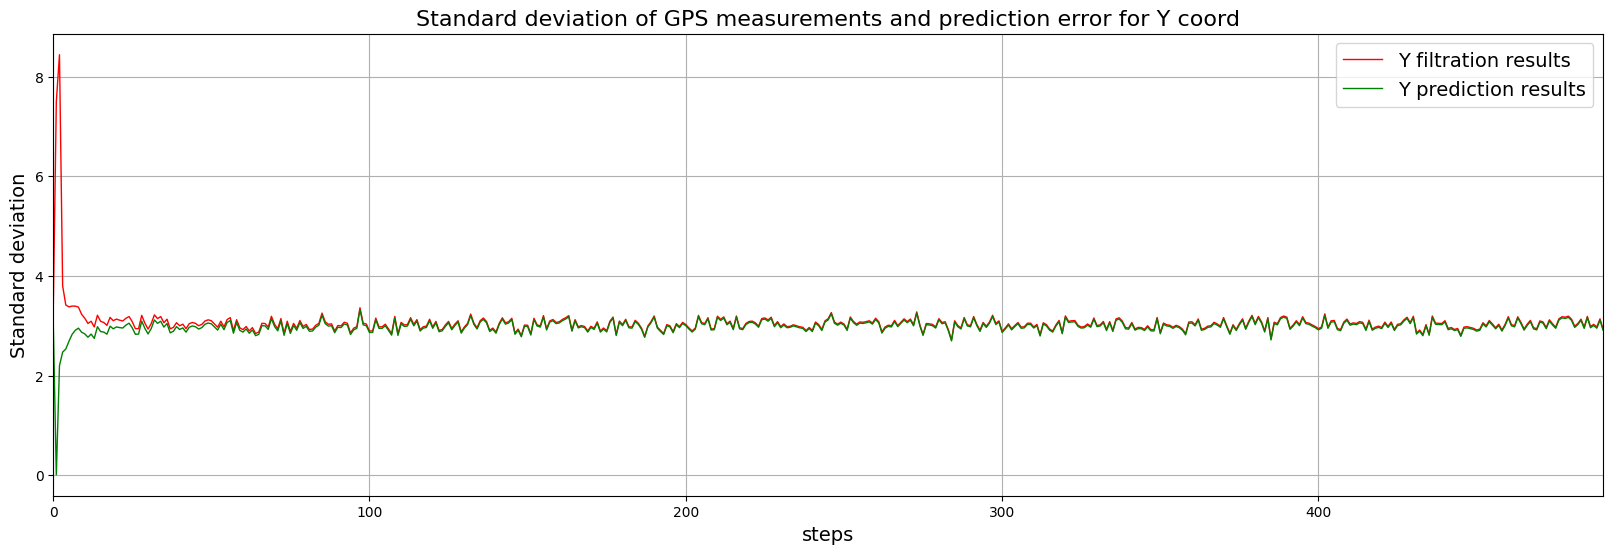

In [ ]:
fig, ax10 = plt.subplots(figsize=(20, 6))
ax10.plot(error_x_pred_f, color='red', label='Std Dev of estimation error for gps measurements', linewidth = 1)
ax10.plot(error_x_filtr_f, color='green', label='Std Dev of prediction error for gps measyrements', linewidth = 1)
plt.grid(True)
plt.xlabel('steps', fontsize=14)
plt.ylabel('Standard deviation', fontsize=14)
plt.title('Standard deviation of GPS measurements filtration and prediction error for X coord', fontsize=16)
plt.xlim([0, n-10])
leg = ax10.legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=1)
plt.legend(['X filtration results','X prediction results'], fontsize=14)
plt.show()

fig, ax101 = plt.subplots(figsize=(20, 6))
ax101.plot(error_y_pred_f, color='red', label='Std Dev of estimation error for gps measyrements', linewidth = 1)
ax101.plot(error_y_filtr_f, color='green', label='Std Dev of prediction error for gps measyrements', linewidth = 1)
plt.grid(True)
plt.xlabel('steps', fontsize=14)
plt.ylabel('Standard deviation', fontsize=14)
plt.title('Standard deviation of GPS measurements and prediction error for Y coord', fontsize=16)
plt.legend(['Y filtration results','Y prediction results'], fontsize=14)
plt.xlim([0, n-10])
leg = ax10.legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=1)
plt.show()

We can see that our standard deviation pushing close to 3, **constant** - from that fact we can again say that we have **stohastic model**.

Deviation of prediction just a little bit lower than filtration as usual.

Part 2

In [ ]:
sigma_v = 0.5
sigma_t = 0.02


def generate_trajectory_():

    a_x = np.random.normal(0, sigma_a, n)
    a_y = np.random.normal(0, sigma_a, n)

    eta_x = np.random.normal(0, sigma_eta, n)
    eta_y = np.random.normal(0, sigma_eta, n)
    eta_v = np.random.normal(0, sigma_v, n)
    eta_t = np.random.normal(0, sigma_t, n)


    v_x = np.zeros(n)
    v_y = np.zeros(n)
    v = np.zeros(n)

    v_x[0] = v_0
    v_y[0] = v_0

    x = np.zeros(n)
    y = np.zeros(n)

    x[0] = x_0
    y[0] = y_0

    z_x = np.zeros(n)
    z_y = np.zeros(n)
    v_m = np.zeros(n)
    t_m = np.zeros(n)


    for i in range(1, n):
        v_x[i] = 10 * np.cos(theta[i-1])
        v_y[i] = 10 * np.sin(theta[i-1])
        v[i] = np.sqrt(v_x[i]**2 + v_y[i]**2)

        x[i] = x[i-1] + 10 * np.cos(theta[i-1])*t + a_x[i-1] * t/2
        y[i] = y[i-1] + 10 * np.sin(theta[i-1])*t + a_y[i-1] * t/2

        z_x[i] = x[i] + eta_x[i]
        z_y[i] = y[i] + eta_y[i]

        v_m[i] = v[i] + eta_v[i]
        t_m[i] = theta[i] + eta_t[i]

    X =  np.array( ([x],
                   [v_x],
                    [y],
                   [v_y]))

    z = np.array([z_x,
                  z_y,
                  v_m,
                  t_m])
    # v = np.sqrt(np.sum(v_x**2, v_y**2))

    return X, z

In [ ]:
X, z = generate_trajectory_()

In [ ]:
def h(X):
  return np.array([X[0],
                   X[2],
                   np.sqrt(X[1]**2 + X[3]**2),
                   np.arctan2(X[3], X[1])])

def dh(X):
  return np.array([[1 ,0 ,0 ,0],
                   [0, 0, 1, 0],
                   [0, X[1]/np.sqrt(X[1]**2 + X[3]**2), 0, X[3]/np.sqrt(X[1]**2 + X[3]**2)],
                   [0, -X[3]/(X[1]**2 + X[3]**2), 0, X[1]/(X[1]**2+X[3]**2)]])

In [ ]:
X.reshape(-1)

array([0.        , 0.5231343 , 1.04612749, ..., 9.64557431, 9.64557431,
       9.64557431])

In [ ]:
def kalman_(z):

    R = np.zeros([4,4])
    R[0,0] = sigma_eta**2
    R[1,1] = sigma_eta**2
    R[2,2] = sigma_v**2
    R[3,3] = sigma_t**2


    x_pred = np.zeros(n, dtype='float64')
    y_pred = np.zeros(n, dtype='float64')
    x_f = np.zeros(n, dtype='float64')
    y_f = np.zeros(n, dtype='float64')

    X = np.array(([z[0][2]],
        [(z[0][2] - z[0][1]) / t],
                [z[1][2]],
        [(z[1][2] - z[1][1]) / t]))

    P_fil = np.eye(4) * 10**4

    for i in range(3, n):
        X = F @ X

        x_pred[i] = X[0]
        y_pred[i] = X[2]

        P_pred = F @ P_fil @ F.T + Q

        H = dh(X.reshape(-1))


        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
        P_fil = (np.eye(np.shape(P_pred)[0]) - K @ H) @ P_pred
        X = X + K @ (z[:,i:(i+1)] - h(X))

        x_f[i] = X[0]
        y_f[i] = X[2]

    return x_pred, y_pred, x_f, y_f


In [ ]:
x_predp, y_predp, x_ff, y_ff = kalman_(z)

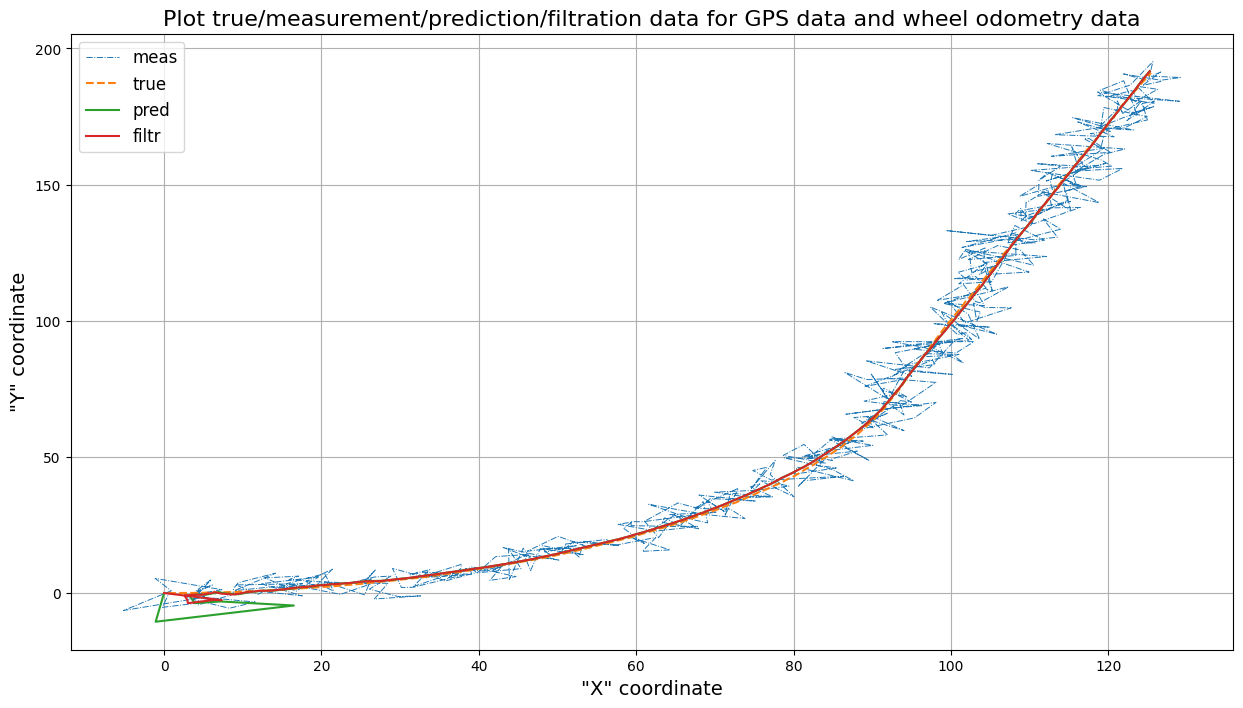

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Plot true/measurement/prediction/filtration data for GPS data and wheel odometry data', fontsize=16)
plt.plot(z[0, :], z[1, :], linestyle='-.', linewidth=0.7)
plt.plot(X[0, :, 1:].T, X[2, :, 1:].T, linestyle='--')
plt.plot(x_predp, y_predp, label='pred')
plt.plot(x_ff, y_ff, label='f', linewidth=1.5)
plt.legend(['meas', 'true', 'pred', 'filtr'], fontsize=12)
plt.xlabel('"X" coordinate', fontsize=14)
plt.ylabel('"Y" coordinate', fontsize=14)

plt.grid()
plt.show()


In [ ]:
M = 500

error_x_pred =  np.zeros(M)
error_x_filtr =  np.zeros(M)

error_y_pred =  np.zeros(M)
error_y_filtr =  np.zeros(M)

for i in range(M):

    X, z = generate_trajectory_()
    x_predp, y_predp, x_ff, y_ff = kalman_(z)

    error_x_pred += (x_predp - z[0,:])**2
    error_x_filtr += (x_ff - z[0,:])**2

    error_y_pred += (y_predp - z[1,:])**2
    error_y_filtr += (y_ff - z[1,:])**2


error_x_pred_f = np.sqrt((error_x_pred)/(M-1))[2:]
error_x_filtr_f = np.sqrt((error_x_filtr)/(M-1))[2:]

error_y_pred_f = np.sqrt((error_y_pred)/(M-1))[2:]
error_y_filtr_f = np.sqrt((error_y_filtr)/(M-1))[2:]

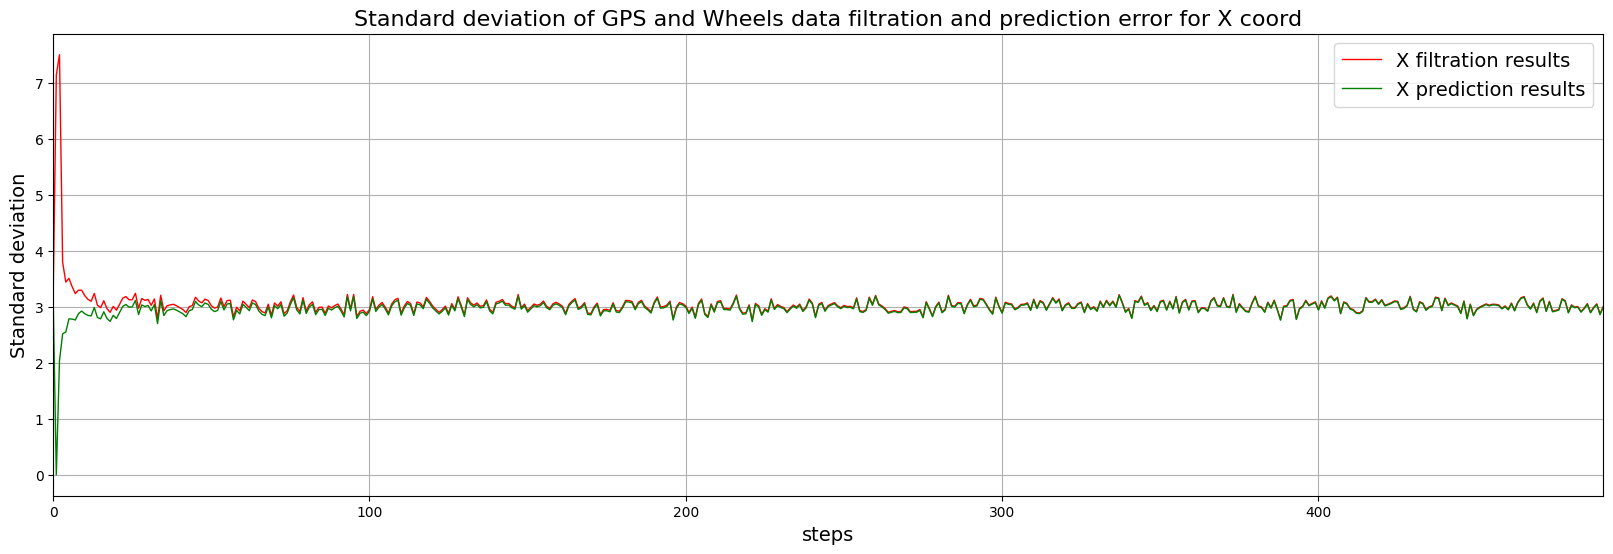

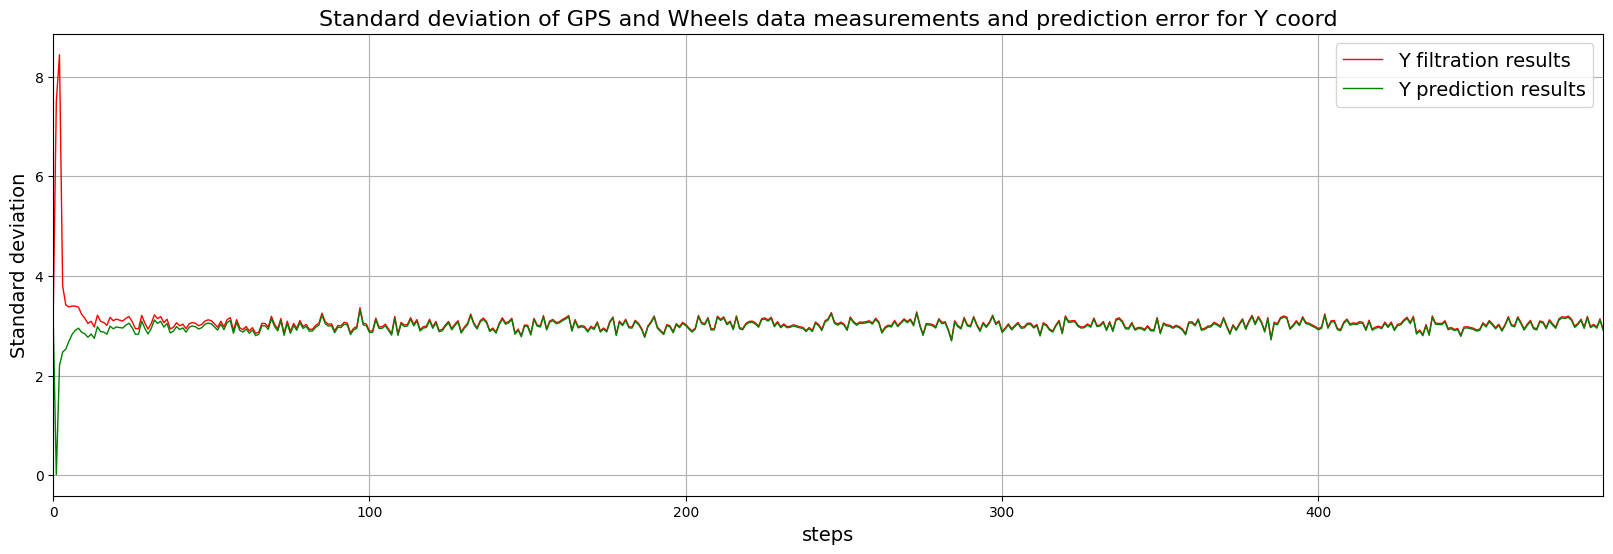

In [ ]:
fig, ax10 = plt.subplots(figsize=(20, 6))
ax10.plot(error_x_pred_f, color='red', label='Std Dev of estimation error for gps measurements', linewidth = 1)
ax10.plot(error_x_filtr_f, color='green', label='Std Dev of prediction error for gps measyrements', linewidth = 1)
plt.grid()
plt.xlabel('steps', fontsize=14)
plt.ylabel('Standard deviation', fontsize=14)
plt.title('Standard deviation of GPS and Wheels data filtration and prediction error for X coord', fontsize=16)
plt.xlim([0, n-10])
leg = ax10.legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=1)
plt.legend(['X filtration results','X prediction results'], fontsize=14)
plt.show()

fig, ax101 = plt.subplots(figsize=(20, 6))
ax101.plot(error_y_pred_f, color='red', label='Std Dev of estimation error for gps measyrements', linewidth = 1)
ax101.plot(error_y_filtr_f, color='green', label='Std Dev of prediction error for gps measyrements', linewidth = 1)
plt.grid()
plt.xlabel('steps', fontsize=14)
plt.ylabel('Standard deviation', fontsize=14)
plt.title('Standard deviation of GPS and Wheels data measurements and prediction error for Y coord', fontsize=16)
plt.legend(['Y filtration results','Y prediction results'], fontsize=14)
plt.xlim([0, n-10])
leg = ax10.legend(loc='center', bbox_to_anchor=(0.5, -0.25), shadow=False, ncol=1)
plt.show()

In comparison with results from Part 1 we can notice that our deviations much closer to constant line y=3, so that indicates that using **both GPS data and wheel odometry** we achieved more accurate results.

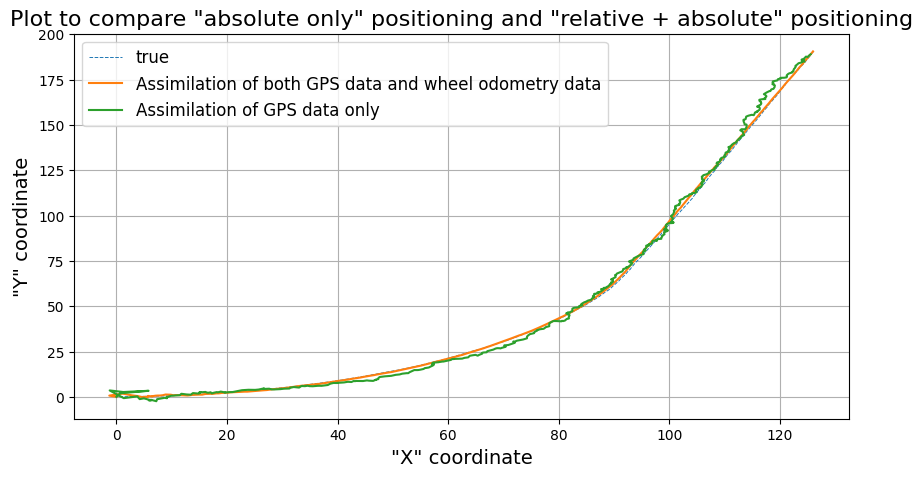

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(X[0,:,1:].T,X[2,:,1:].T, linestyle='--', label = 'true', linewidth = 0.7)
plt.plot(x_ff,y_ff, label = 'Assimilation of both GPS data and wheel odometry data')
plt.plot(x_f,y_f, label = 'Assimilation of GPS data only')
plt.title('Plot to compare "absolute only" positioning and "relative + absolute" positioning', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.xlabel('"X" coordinate', fontsize=14)
plt.ylabel('"Y" coordinate', fontsize=14)
plt.show()




**Conclusions:** this task was a little bit challenging for us because of the part 2, working with **angles** is a bit **tricky** work due to mathematical limitations, but we succesfully implemented Kalman algorithm for that and our results shows that our final results using both GPS data and wheel odometry are higher than using just GPS. **More parameters** taken into account => **better results.**